CNN Testing File for DataSci 207 Final Project 

Created by Daelyn Bergsman on 11/8/23

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os


# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.utils import to_categorical

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline



Loading the data for the filemapping, and for the labels

In [2]:
IMAGE_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\images\\images\\' # replace with your path
FILEMAPPING_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\gz2_filename_mapping.csv' # replace with your path
LABEL_PATH = 'C:\\Users\\daely\\Documents\\Python\\Projects\\DataSci207\\data\\gz2_hart16.csv' # replace with your path

In [3]:
map = pd.read_csv(
    FILEMAPPING_PATH 
)
labels = pd.read_csv(
    LABEL_PATH 
)


print('Shape of mapping:', map.shape)
print('Shape of label data:', labels.shape)
map.head()

Shape of mapping: (355990, 3)
Shape of label data: (239695, 231)


,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5


In [4]:
# load column names from file into a list
sdss_headers = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify groups of primary columns
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
object_class_labels = ['sdss_clean_class_name']
star_class_labels = ['stellar_subclass_MK']
galaxy_class_labels =['gz2_subclass_hubble']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
object_features = ['redshift_final', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)
sdss_primary.head()

C:\Users\daely\AppData\Local\Temp\ipykernel_18896\2507121498.py:20: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,sdss_clean_class_code,stellar_subclass_MK,stellar_subclass_code,gz2_subclass_hubble,gz2_subclass_code,...,gz2_flag_arms_unsure,petroR90_r_log,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,1237651252584448100,192933,236.355530,54.820911,galaxy,0,unclassified,8,SBc,5,...,False,2.263365,-2.299111,85.88830,2.09786,1.09673,0.63014,NaN,NaN,NaN
1,1237651252584448112,<NA>,236.342000,54.802830,galaxy,0,unclassified,8,unclassified,11,...,NaN,1.878837,-1.543686,88.50900,2.39652,1.32288,0.71409,NaN,NaN,NaN
2,1237651252584251555,32264,235.891464,55.133472,galaxy,0,unclassified,8,SBc,5,...,False,2.352307,-2.803127,77.52239,2.37586,1.12715,0.67207,NaN,NaN,NaN
3,1237651252584317089,32265,236.063721,55.035847,galaxy,0,unclassified,8,Sc,9,...,False,2.218923,-2.673609,84.18209,1.77608,0.65633,0.23047,NaN,NaN,NaN
4,1237655130907213985,<NA>,236.150100,54.775720,galaxy,0,unclassified,8,unclassified,11,...,NaN,1.288587,-2.440658,89.05857,1.44878,0.69195,0.46791,NaN,NaN,NaN


In [5]:
# create new mapping with needed data
y = sdss_primary[['dr8objid','gz2_filenumber','gz2_subclass_code']]
y = y.dropna()
y.head()

,dr8objid,gz2_filenumber,gz2_subclass_code
0,1237651252584448100,192933,5
2,1237651252584251555,32264,5
3,1237651252584317089,32265,9
5,1237651252584317111,192932,10
8,1237655130907214001,249746,9


In [198]:
# now take the boolean flags for galaxy type and instead create a dense encoding for labels consistent with the model
y_dense = y.reset_index()
y_dense['label'] = y_dense['gz2_subclass_code']

y_dense['image_num'] = y_dense['gz2_filenumber']
y_dense = y_dense.drop(['index', 'gz2_subclass_code','gz2_filenumber'], axis=1)
y_dense.head()

,dr8objid,label,image_num
0,1237651252584448100,5,192933
1,1237651252584251555,5,32264
2,1237651252584317089,9,32265
3,1237651252584317111,10,192932
4,1237655130907214001,9,249746


In [199]:
# setting number of classes to be referenced later
class_num = len(np.unique(y_dense['label']))
print('Number of classes: ', class_num)

print(y_dense['label'].value_counts())


Number of classes:  11
label
2     55380
1     43812
9     41453
8     26106
5     24506
4     17173
0      9715
10     2747
6       864
7       479
3       137
Name: count, dtype: int64


In [200]:
# dropping labels with lowest amount of data to train with more images
labels_to_keep = [0, 1, 2, 4, 5, 8, 9, 10]
y_reduced = y_dense[y_dense['label'].isin(labels_to_keep)]
y_reduced['label'] = y_reduced['label'].replace([8, 9, 10],[3, 6, 7])
#resetting class numbers
class_num = len(np.unique(y_reduced['label']))
print('Number of classes: ', class_num)
print(y_reduced['label'].value_counts())

Number of classes:  8
label
2    55380
1    43812
6    41453
3    26106
5    24506
4    17173
0     9715
7     2747
Name: count, dtype: int64


C:\Users\daely\AppData\Local\Temp\ipykernel_18896\28003475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_reduced['label'] = y_reduced['label'].replace([8, 9, 10],[3, 6, 7])


In [201]:
# read list of images
indx=0
image_name = []
# goes through the list of images to get their labels

for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    image_name.append(img)

print('Number of images:', len(image_name))

Number of images: 243434


Now take a look at the image data and work on getting the mapping from y to be 1 to 1

In [212]:
img_list = []

for i in range(len(image_name)):
    img = int(image_name[i][:-4])
    img_list.append(img)


y_rel = y_reduced[y_reduced['image_num'].astype(int).isin(img_list)]
y_rel = y_rel[['image_num', 'label']]
z = y_rel['label'].value_counts()

y_final = y_rel.astype({'image_num':'string'})

# sample by number of classes
y_final = y_final.groupby('label')['image_num'].apply(lambda s: s.sample(2000))
y_final = pd.DataFrame(y_final).reset_index()[['label','image_num']]


print(y_final['image_num'].dtype)
print('Shape of y final:', y_final.shape)

label_ref = y_final.image_num.to_list()

IMAGE_SIZE = (64, 64)
CONTRAST_FACTOR = 2
DELTA = 0.3

string
Shape of y final: (16000, 2)


In [213]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 424, 424, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in label_ref:
                y_mini.append(y_final[y_final['image_num']==img.split('.')[0]]['label'].item())
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size = (424,424)
        )
        
        img = tf.image.crop_to_bounding_box(img, 148, 148, 128, 128)

        # adjust contrast
        img = tf.image.adjust_contrast(img, contrast_factor=1)
        
        # adjust brightness
        img = tf.image.adjust_brightness(img, delta=DELTA)

        # transform image to array
        img = img_to_array(img)
        
        # append to images
        images_mini.append(img)
       

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [214]:
# run and load in images with preprocessing
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (16000, 128, 128, 3)
y_mini shape (16000,)


In [217]:


def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 424, 424, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0],splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0],splits[0]+splits[1]])
    ### image transformation on training, validation, and test data ###
    ###################################################################

    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=0.1)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [218]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (19200, 128, 128, 3)
y_train shape (19200,)
X_val shape (3200, 128, 128, 3)
y_val shape (3200,)
X_test shape (3200, 128, 128, 3)
y_test shape (3200,)


<Axes: xlabel='count'>

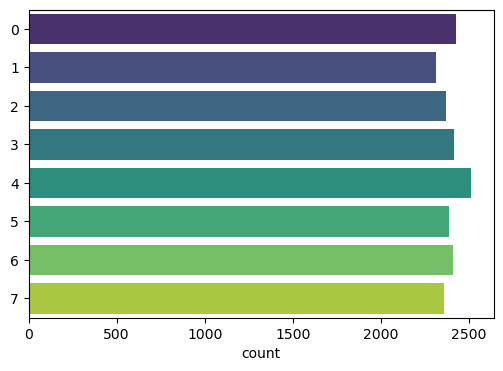

In [219]:
plt.figure(figsize=(6, 4))
sns.countplot(y=y_train, palette='viridis')

Print training data examples:


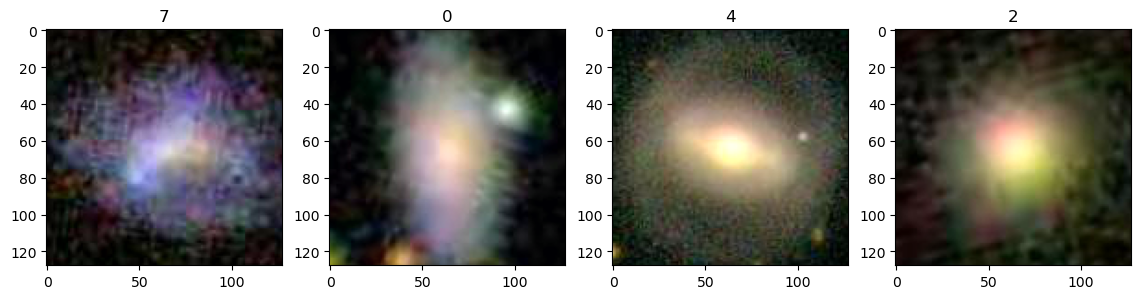

In [220]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])


In [225]:
model = tf.keras.Sequential()


# -------------------------------------------------------
# add first convolution layer to the model

model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    data_format='channels_last',
    name='conv_1', activation = 'relu'))

# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

model.add(tf.keras.layers.BatchNormalization())

# -------------------------------------------------------
# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2', activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)

model.add(tf.keras.layers.Dropout(
    rate=0.5))

# -------------------------------------------------------
# add 3rd convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_3', activation='relu'))

# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_3'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

# -------------------------------------------------------
# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 

model.add(tf.keras.layers.Dense(
    units=2048,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_2', 
    activation='relu'))    

model.add(tf.keras.layers.Dropout(
    rate=0.5))  

# add the last fully connected layer
model.add(tf.keras.layers.Dense(
    units=class_num,
    name='fc_3',
    activation='softmax'))

# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 128, 128, 3))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_28 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 dropout_43 (Dropout)        (None, 16, 16, 64)        0         
                                                     

In [226]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy']) 

In [227]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num CPUs Available:  1
Num GPUs Available:  0


In [233]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(12345)
np.random.seed(12345)
history = model.fit(X_train, y_train,
                    epochs=50, 
                    validation_data=(X_val, y_val), shuffle=True
)

Epoch 1/15
600/600 [==============================] - 49s 81ms/step - loss: 1.2608 - accuracy: 0.5166 - val_loss: 1.3363 - val_accuracy: 0.5169
Epoch 2/15
600/600 [==============================] - 49s 82ms/step - loss: 1.2352 - accuracy: 0.5327 - val_loss: 1.3431 - val_accuracy: 0.5131
Epoch 3/15
600/600 [==============================] - 49s 81ms/step - loss: 1.2352 - accuracy: 0.5303 - val_loss: 1.4809 - val_accuracy: 0.5006
Epoch 4/15
600/600 [==============================] - 48s 79ms/step - loss: 1.2021 - accuracy: 0.5431 - val_loss: 1.5631 - val_accuracy: 0.5091
Epoch 5/15
600/600 [==============================] - 48s 79ms/step - loss: 1.1760 - accuracy: 0.5522 - val_loss: 2.1350 - val_accuracy: 0.5131
Epoch 6/15
600/600 [==============================] - 47s 79ms/step - loss: 1.1884 - accuracy: 0.5450 - val_loss: 1.3319 - val_accuracy: 0.4984
Epoch 7/15
600/600 [==============================] - 48s 79ms/step - loss: 1.2101 - accuracy: 0.5390 - val_loss: 1.3534 - val_accuracy:

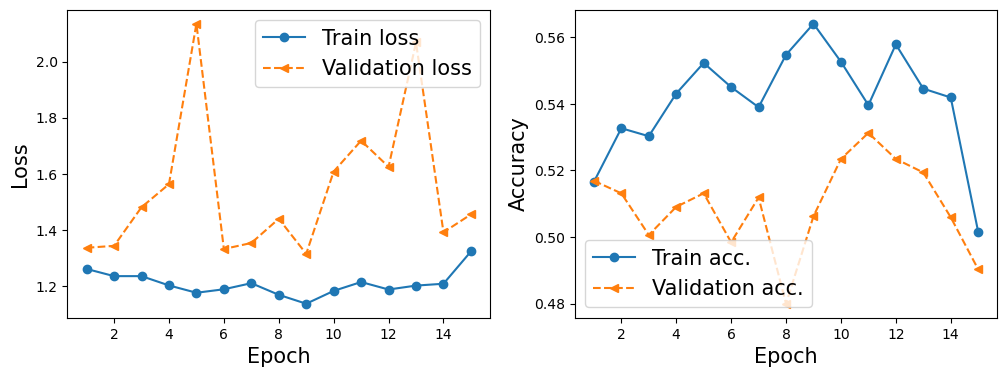

In [234]:
#plot the history of the model
def model_history_plot(model):
    hist = model.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

model_history_plot(history)

In [235]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)

Evaluate on test data
25/25 [==============================] - 1s 39ms/step - loss: 1.8053 - accuracy: 0.4909


100/100 [==============================] - 1s 11ms/step


Text(50.722222222222214, 0.5, 'True')

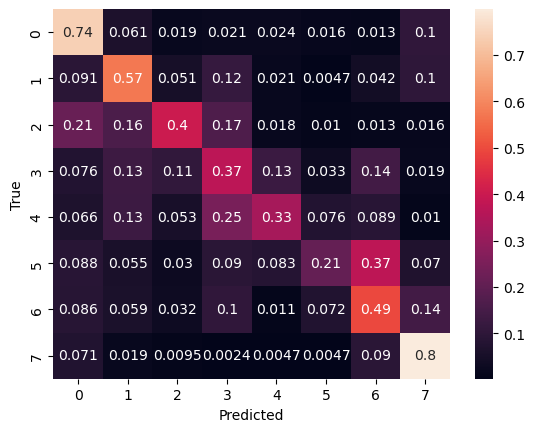

In [236]:
#Predict
predictions = model.predict(X_test)
predictions = tf.argmax(predictions, axis=-1)

cm = tf.math.confusion_matrix(y_test, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

sns.heatmap(
    cm, annot=True,)
plt.xlabel("Predicted")
plt.ylabel("True")